In [2]:
import os
import random
import json
import numpy as np
import pandas as pd
import librosa
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from pathlib import Path
from tqdm.auto import tqdm

# Settings
SR = 16000
WINDOW_SEC = 5.0
HOP_SEC = 2.5
N_MFCC = 40

BATCH_SIZE = 16
EPOCHS = 15
LR = 1e-4
PATIENCE = 6
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

BASE_DIR = r"C:\Users\Raj Dhanush\OneDrive\Desktop\DEEPLEARNING PROJECT"
TRAIN_AUDIO_DIR = os.path.join(BASE_DIR, "depression_detection", "data", "train")
FEATURE_DIR = os.path.join(BASE_DIR, "features")
TRAIN_CSV = os.path.join(BASE_DIR, "train_split_Depression_AVEC2017.csv")
MODEL_DIR = os.path.join(BASE_DIR, "model_checkpoints")
os.makedirs(MODEL_DIR, exist_ok=True)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)


Using device: cpu


In [4]:
# Feature extraction function
def extract_mfcc(y, sr=SR, n_mfcc=N_MFCC):
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    mfcc = librosa.util.normalize(mfcc)
    return mfcc.astype(np.float32)

# Process audio files into fixed-length windows saved as npy
def process_file_to_windows(wav_path, out_dir, window_sec=WINDOW_SEC, hop_sec=HOP_SEC, sr=SR):
    y, _ = librosa.load(wav_path, sr=sr)
    total = len(y)
    window_samples = int(window_sec * sr)
    hop_samples = int(hop_sec * sr)
    starts = list(range(0, max(1, total - window_samples + 1), hop_samples))
    if starts and (starts[-1] + window_samples < total):
        starts.append(total - window_samples)
    if not starts:
        starts = [0]
    saved = []
    for i, s in enumerate(starts):
        chunk = y[s:s+window_samples]
        mfcc = extract_mfcc(chunk, sr=sr)
        base = Path(wav_path).stem
        fname = f"{base}_win{i}.npy"
        out_path = os.path.join(out_dir, fname)
        np.save(out_path, mfcc)
        saved.append(out_path)
    return saved

# Preprocessing pipeline (run if mapping json not found)
def preprocess_all_train(train_csv=TRAIN_CSV, audio_dir=TRAIN_AUDIO_DIR, feature_dir=FEATURE_DIR):
    os.makedirs(feature_dir, exist_ok=True)
    df = pd.read_csv(train_csv)
    mapping = []
    for _, row in tqdm(df.iterrows(), total=len(df), desc="Preprocess train"):
        pid = str(int(row['Participant_ID']))
        wav_name = f"{pid}_AUDIO.wav"
        wav_path = os.path.join(audio_dir, wav_name)
        if not os.path.exists(wav_path):
            print("Missing:", wav_path)
            continue
        saved = process_file_to_windows(wav_path, feature_dir)
        for p in saved:
            mapping.append({"file": p, "participant": pid, "label": int(row["PHQ8_Binary"])})
    with open(os.path.join(feature_dir, "mapping.json"), "w") as f:
        json.dump(mapping, f)
    print("Total windows saved:", len(mapping))
    return mapping

mapping_path = os.path.join(FEATURE_DIR, "mapping.json")
if not os.path.exists(mapping_path):
    print("Mapping not found — starting preprocessing (this will take time).")
    preprocess_all_train()
else:
    print("Mapping already exists at:", mapping_path)


Mapping already exists at: C:\Users\Raj Dhanush\OneDrive\Desktop\DEEPLEARNING PROJECT\features\mapping.json


In [5]:
with open(mapping_path, "r") as f:
    mapping = json.load(f)
print("Total windows:", len(mapping))

from collections import Counter
cnt = Counter([m["participant"] for m in mapping])
print("Example windows per participant (first 8):", list(cnt.items())[:8])


Total windows: 38682
Example windows per participant (first 8): [('303', 394), ('304', 317), ('305', 681), ('310', 337), ('312', 315), ('313', 301), ('315', 390), ('316', 347)]


In [6]:
class WindowDataset(Dataset):
    def __init__(self, mapping, max_frames=None):
        self.mapping = mapping
        self.max_frames = max_frames or self._compute_max_frames()
    
    def _compute_max_frames(self):
        maxf = 0
        for entry in self.mapping:
            arr = np.load(entry["file"])
            maxf = max(maxf, arr.shape[1])  # arr.shape = (n_mfcc, frames)
        return maxf

    def __len__(self):
        return len(self.mapping)

    def __getitem__(self, idx):
        entry = self.mapping[idx]
        arr = np.load(entry["file"])  # (n_mfcc, frames)
        n_mfcc, frames = arr.shape
        mf = self.max_frames
        if frames < mf:
            arr = np.pad(arr, ((0,0), (0, mf-frames)), mode='constant')
        elif frames > mf:
            arr = arr[:, :mf]
        x = torch.tensor(arr, dtype=torch.float).unsqueeze(0)  # (1, n_mfcc, max_frames)
        y = torch.tensor(entry["label"], dtype=torch.float)
        return x, y

dataset = WindowDataset(mapping)
print("Dataset windows:", len(dataset), "max_frames:", dataset.max_frames)


Dataset windows: 38682 max_frames: 157


In [7]:
df_map = pd.DataFrame(mapping)
participants = df_map['participant'].unique()
part_labels = df_map.groupby('participant')['label'].first().astype(int)

train_parts, val_parts = train_test_split(
    participants, test_size=0.2, random_state=SEED,
    stratify=[part_labels.get(p, 0) for p in participants]
)

train_idx = df_map[df_map['participant'].isin(train_parts)].index.tolist()
val_idx   = df_map[df_map['participant'].isin(val_parts)].index.tolist()

train_ds = Subset(dataset, train_idx)
val_ds   = Subset(dataset, val_idx)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

print("Train windows:", len(train_ds), "Val windows:", len(val_ds))


Train windows: 30789 Val windows: 7893


In [8]:
class RNNBiLSTM(nn.Module):
    def __init__(self, nmfcc=N_MFCC, rnn_hidden=128, lstm_hidden=128, nlayers=1):
        super().__init__()
        self.rnn_hidden = rnn_hidden
        self.lstm_hidden = lstm_hidden

        self.rnn = nn.RNN(
            input_size=nmfcc,
            hidden_size=rnn_hidden,
            num_layers=nlayers,
            batch_first=True,
            bidirectional=True
        )
        self.lstm = nn.LSTM(
            input_size=2*rnn_hidden,
            hidden_size=lstm_hidden,
            num_layers=nlayers,
            batch_first=True,
            bidirectional=True
        )
        self.classifier = nn.Sequential(
            nn.Linear(2*lstm_hidden, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        # x: (batch, 1, nmfcc, max_frames)
        batch, channel, nmfcc, frames = x.shape
        # Permute to (batch, 1, frames, nmfcc), then squeeze channel
        x = x.permute(0, 1, 3, 2)  # (batch, 1, frames, nmfcc)
        x = x.squeeze(1)           # (batch, frames, nmfcc)
        rnn_out, _ = self.rnn(x)   # (batch, frames, 2*rnn_hidden)
        lstm_out, _ = self.lstm(rnn_out)  # (batch, frames, 2*lstm_hidden)
        out = lstm_out[:, -1, :]   # Use last time step
        logits = self.classifier(out).squeeze(1)
        return logits

model = RNNBiLSTM().to(DEVICE)
print(model)


RNNBiLSTM(
  (rnn): RNN(40, 128, batch_first=True, bidirectional=True)
  (lstm): LSTM(256, 128, batch_first=True, bidirectional=True)
  (classifier): Sequential(
    (0): Linear(in_features=256, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=64, out_features=1, bias=True)
  )
)


In [9]:
print("Testing first few batches for DataLoader...")
for i, (xb, yb) in enumerate(train_loader):
    print(f"Batch {i}: x={xb.shape}, y={yb.shape}")
    if i >= 2:
        break
print("✅ Batch test completed.")


Testing first few batches for DataLoader...
Batch 0: x=torch.Size([16, 1, 40, 157]), y=torch.Size([16])
Batch 1: x=torch.Size([16, 1, 40, 157]), y=torch.Size([16])
Batch 2: x=torch.Size([16, 1, 40, 157]), y=torch.Size([16])
✅ Batch test completed.


In [10]:
from tqdm.notebook import tqdm

optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.BCEWithLogitsLoss()

best_val = float('inf')
pat = 0
train_losses, val_losses = [], []

for epoch in range(1, EPOCHS + 1):
    print(f"\nEpoch {epoch}/{EPOCHS}", flush=True)
    model.train()
    train_loss = 0.0
    for xb, yb in tqdm(train_loader, desc=f"Train E{epoch}"):
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * xb.size(0)
    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)

    model.eval()
    val_loss = 0.0
    preds, trues = [], []
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            logits = model(xb)
            loss = criterion(logits, yb)
            val_loss += loss.item() * xb.size(0)
            probs = torch.sigmoid(logits).cpu().numpy()
            preds.extend(probs.tolist())
            trues.extend(yb.cpu().numpy().tolist())
    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)
    val_pred = [1 if p > 0.5 else 0 for p in preds]
    val_acc = accuracy_score(trues, val_pred)
    val_f1 = f1_score(trues, val_pred, zero_division=0)
    print(f"Epoch {epoch}: train_loss={train_loss:.4f} val_loss={val_loss:.4f} acc={val_acc:.4f} f1={val_f1:.4f}")

    if val_loss < best_val:
        best_val = val_loss
        pat = 0
        torch.save(model.state_dict(), os.path.join(MODEL_DIR, "best_rnn_bilstm_mfcc.pth"))
        print("✅ Saved best model.")
    else:
        pat += 1
        if pat >= PATIENCE:
            print("🛑 Early stopping triggered.")
            break

print("✅ Training completed.")



Epoch 1/15


Train E1:   0%|          | 0/1925 [00:00<?, ?it/s]

Epoch 1: train_loss=0.5952 val_loss=0.6014 acc=0.7083 f1=0.0000
✅ Saved best model.

Epoch 2/15


Train E2:   0%|          | 0/1925 [00:00<?, ?it/s]

Epoch 2: train_loss=0.5887 val_loss=0.6032 acc=0.7083 f1=0.0000

Epoch 3/15


Train E3:   0%|          | 0/1925 [00:00<?, ?it/s]

Epoch 3: train_loss=0.5853 val_loss=0.6028 acc=0.7083 f1=0.0000

Epoch 4/15


Train E4:   0%|          | 0/1925 [00:00<?, ?it/s]

Epoch 4: train_loss=0.5818 val_loss=0.5955 acc=0.7082 f1=0.0035
✅ Saved best model.

Epoch 5/15


Train E5:   0%|          | 0/1925 [00:00<?, ?it/s]

Epoch 5: train_loss=0.5801 val_loss=0.6013 acc=0.7089 f1=0.0052

Epoch 6/15


Train E6:   0%|          | 0/1925 [00:00<?, ?it/s]

Epoch 6: train_loss=0.5830 val_loss=0.5867 acc=0.7172 f1=0.1442
✅ Saved best model.

Epoch 7/15


Train E7:   0%|          | 0/1925 [00:00<?, ?it/s]

Epoch 7: train_loss=0.5746 val_loss=0.5824 acc=0.7138 f1=0.0576
✅ Saved best model.

Epoch 8/15


Train E8:   0%|          | 0/1925 [00:00<?, ?it/s]

Epoch 8: train_loss=0.5728 val_loss=0.5922 acc=0.7086 f1=0.0026

Epoch 9/15


Train E9:   0%|          | 0/1925 [00:00<?, ?it/s]

Epoch 9: train_loss=0.5739 val_loss=0.6014 acc=0.7083 f1=0.0000

Epoch 10/15


Train E10:   0%|          | 0/1925 [00:00<?, ?it/s]

Epoch 10: train_loss=0.5711 val_loss=0.5993 acc=0.7085 f1=0.0017

Epoch 11/15


Train E11:   0%|          | 0/1925 [00:00<?, ?it/s]

Epoch 11: train_loss=0.5692 val_loss=0.5831 acc=0.7092 f1=0.0103

Epoch 12/15


Train E12:   0%|          | 0/1925 [00:00<?, ?it/s]

Epoch 12: train_loss=0.5737 val_loss=0.6045 acc=0.7085 f1=0.0026

Epoch 13/15


Train E13:   0%|          | 0/1925 [00:00<?, ?it/s]

Epoch 13: train_loss=0.5724 val_loss=0.5869 acc=0.7092 f1=0.0129
🛑 Early stopping triggered.
✅ Training completed.


In [12]:
import librosa
import torch
import os

def extract_mel_for_inference(audio, sr=SR, n_mfcc=N_MFCC):
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)
    mfcc = librosa.util.normalize(mfcc)
    return torch.tensor(mfcc, dtype=torch.float).unsqueeze(0).unsqueeze(0)  # (1,1,n_mfcc,frames)

def predict_audio(model, file_path):
    model.eval()
    audio, sr = librosa.load(file_path, sr=SR)
    features = extract_mel_for_inference(audio)
    features = features.to(DEVICE)
    with torch.no_grad():
        logits = model(features)
        prob = torch.sigmoid(logits).item()
        label = "Depressed 😔" if prob > 0.5 else "Not Depressed 🙂"
    print(f"Prediction: {label}  |  Confidence: {prob:.3f}")

# Example usage
test_audio = os.path.join(TRAIN_AUDIO_DIR, "303_AUDIO.wav")
predict_audio(model, test_audio)


Prediction: Not Depressed 🙂  |  Confidence: 0.260


In [14]:
import sounddevice as sd
import numpy as np
import torch
import librosa

def record_audio(duration_sec=5, sr=SR):
    print(f"🎙️ Recording {duration_sec} seconds of audio...")
    audio = sd.rec(int(duration_sec * sr), samplerate=sr, channels=1, dtype='float32')
    sd.wait()
    print("✅ Recording complete.")
    return audio.flatten()

def extract_mel_for_inference(y, sr=SR, n_mfcc=N_MFCC):
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    mfcc = librosa.util.normalize(mfcc)
    mfcc = mfcc.astype(np.float32)
    return torch.tensor(mfcc).unsqueeze(0).unsqueeze(0)  # (1,1,n_mfcc,frames)

def predict_live_audio(duration_sec=5):
    y = record_audio(duration_sec)
    y = y / (np.max(np.abs(y)) + 1e-9)  # Normalize audio amplitude
    mel = extract_mel_for_inference(y)
    mel = mel.to(DEVICE)
    model.eval()
    with torch.no_grad():
        logits = model(mel)
        prob = torch.sigmoid(logits).item()
    label = "Depressed 😔" if prob > 0.5 else "Not Depressed 🙂"
    print(f"🎧 Live Prediction: {label} | Confidence: {prob:.3f}")

# Run live prediction once
predict_live_audio(duration_sec=5)


🎙️ Recording 5 seconds of audio...
✅ Recording complete.
🎧 Live Prediction: Not Depressed 🙂 | Confidence: 0.150


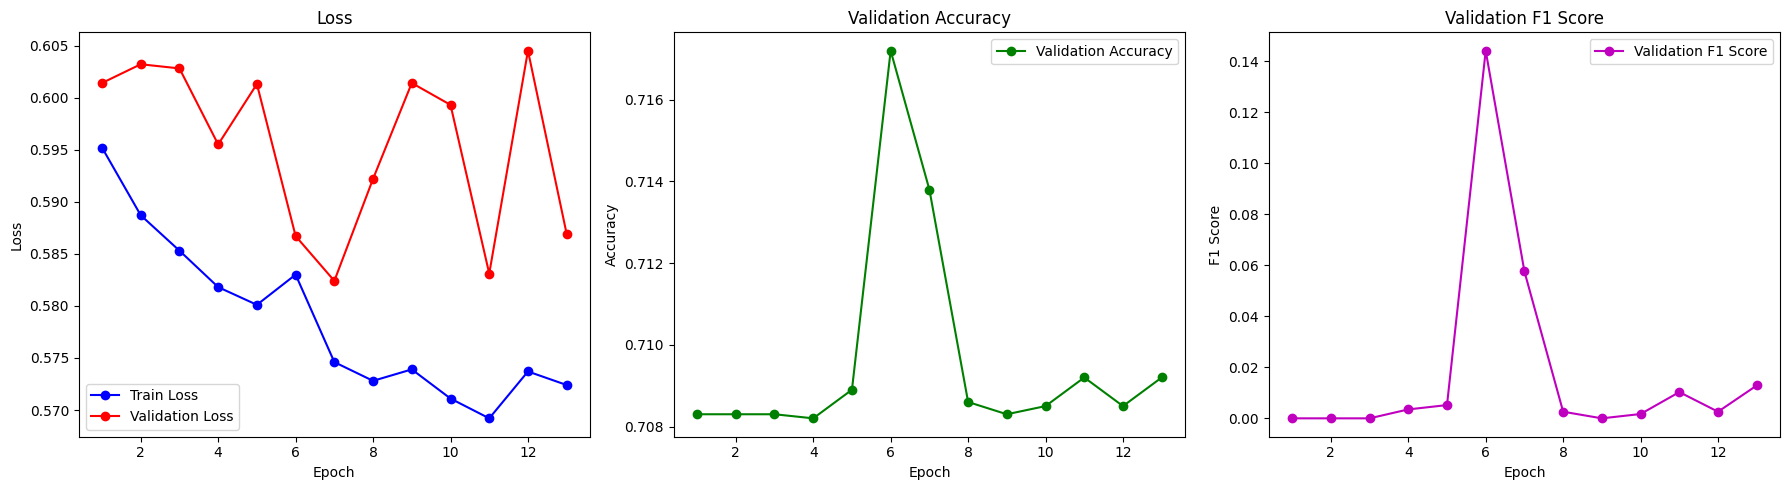

In [15]:
import matplotlib.pyplot as plt

train_losses = [0.5952, 0.5887, 0.5853, 0.5818, 0.5801, 0.5830, 0.5746, 0.5728, 0.5739, 0.5711, 0.5692, 0.5737, 0.5724]
val_losses = [0.6014, 0.6032, 0.6028, 0.5955, 0.6013, 0.5867, 0.5824, 0.5922, 0.6014, 0.5993, 0.5831, 0.6045, 0.5869]
val_accs = [0.7083, 0.7083, 0.7083, 0.7082, 0.7089, 0.7172, 0.7138, 0.7086, 0.7083, 0.7085, 0.7092, 0.7085, 0.7092]
val_f1s = [0.0, 0.0, 0.0, 0.0035, 0.0052, 0.1442, 0.0576, 0.0026, 0.0, 0.0017, 0.0103, 0.0026, 0.0129]

epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
plt.plot(epochs, train_losses, 'bo-', label='Train Loss')
plt.plot(epochs, val_losses, 'ro-', label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(epochs, val_accs, 'go-', label='Validation Accuracy')
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(epochs, val_f1s, 'mo-', label='Validation F1 Score')
plt.title('Validation F1 Score')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend()

plt.tight_layout()
plt.show()
